In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import pyccl as ccl
from scipy.optimize import minimize
import emcee
import corner
import astropy.cosmology
import astropy.units as u
from chainconsumer import ChainConsumer
import pickle
import pandas as pd

In [2]:
cosmo = astropy.cosmology.FlatLambdaCDM(71, 0.2648, Ob0=0.0448) # cosmoDC2 params

#PICK A BIN SIZE
# z_arr = np.array([0.25+0.1*i for i in range(10)]) #10 BINS
z_arr = np.array([0.3+0.2*i for i in range(5)]) #5 BINS

angles = cosmo.arcsec_per_kpc_comoving(z_arr)
angles = (angles*8000*u.kpc).to(u.arcmin).value

# Load Data

In [3]:
#read the data
filename = 'MCMC_files/all_outputs_dec3_cModel'
infile = open(filename,'rb')
catalog_correlations, ccl_predictions, nz_values, covariances = pickle.load(infile)
infile.close()

oto_5, otm_5, tot_5 = catalog_correlations
oto_5_ccl, otm_5_ccl, tot_5_ccl = ccl_predictions
nz_5_oto, nz_5_otm, nz_5_tot = nz_values
oto_cov_5, otm_cov_5, tot_cov_5 = covariances

del catalog_correlations
del ccl_predictions
del nz_values
del covariances

In [4]:
def load_data(data_array, bins):
    '''data_array, eg. true_5 or true_10
    '''
    df_list = []
    for i in range(bins):
        df_list.append(pd.DataFrame(data_array[i]).rename(index={0:f"theta_{i}", 1:f"w_{i}", 2:f"werr_{i}"}).T)
    return pd.concat(df_list, axis=1)

In [5]:
def load_nz(nz_array, bins):
    '''nz_array, eg. nz_5_data or nz_10_data
    '''
    df_list = []
    for i in range(bins):
        df_list.append(pd.DataFrame(nz_array[i]).rename(index={0:f"Nz_{i}", 
                                                               1:f"z_{i}"}).T.reindex(columns=[f"z_{i}", 
                                                                                               f"Nz_{i}"]))
    return pd.concat(df_list, axis=1)

# Define Model

In [6]:
def model(pars, theta, nz_out, masks):
    Omega_m, b1, b2, b3, b4, b5 = pars
    b = np.array([b1, b2, b3, b4, b5])
    cosmo = ccl.Cosmology(Omega_b=0.0448, Omega_c=Omega_m-0.0448, n_s=0.96, sigma8=0.8, h=0.7)
    tracers = [ccl.NumberCountsTracer(cosmo, True, dndz=(nz_out[f'z_{i}'], nz_out[f'Nz_{i}']),
                                  bias=(nz_out[f'z_{i}'], b[i]*np.ones_like(nz_out[f'z_{i}']))) for i in range(5)]
    ell = np.unique(np.geomspace(0.1, 30000, 75).astype(int))
    cls_all = [ccl.angular_cl(cosmo, tracers[i], tracers[i], ell) for i in range(5)]
    corr_func = [ccl.correlation(cosmo, ell, cls_all[i], theta[masks[i]]) for i in range(5)]
    return corr_func

def prior(pars):
    Omega_m, b1, b2, b3, b4, b5 = pars
    if (0.15 < Omega_m < 0.42) & (0.5 < b1 < 3) & (0.5 < b2 < 3) & (0.5 < b3 < 3) & (0.5 < b4 < 3) & (0.5 < b5 < 3):
        return 0
    else:
       return -np.inf

def log_like(pars, theta, nz_out, results, inv_cov, masks):
    pri = prior(pars)
    if np.isfinite(pri):
        w_model = model(pars, theta, nz_out, masks)
        resid = [np.einsum('i, ij, j', results[f'w_{i}'][masks[i]]-w_model[i], inv_cov[i], results[f'w_{i}'][masks[i]]-w_model[i]) for i in range(5)]
        resid = -0.5*np.sum(resid)
        return resid+pri
    else:
        return pri

In [24]:
nsteps=600
discard_steps=0
initial = [0.3, 0.9, 0.9, 1.1, 1.3, 1.5,]

In [25]:
#TEST
# tarr = [0.31835221487298926, 0.7079051782975889, 0.9055648972493031, 1.048465065365917, 1.1421415813258002, 1.2465698621426347]
tarr = [0.28835221487298926, 0.66079051782975889, 0.8055648972493031, 0.9148465065365917, 1.1421415813258002, 1.2465698621426347]

data = load_data(oto_5, 5)
nz_data = load_nz(nz_5_oto, 5)
cov = oto_cov_5

masks = [np.where(data[f'theta_{i}'] > angles[i])[0] for i in range(len(angles))]
theta = (data['theta_0']/60.).astype(np.float64)
inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
                                             masks[i][0]:masks[i][-1]+1]) for i in range(5)], dtype='object')

print(log_like(tarr, theta, nz_data, data, inv_cov, masks))

-29.90820151737386


# Run Chains

In [9]:
# #TRUTH
# data = load_data(true_5, 5)
# nz_data = load_nz(nz_5_data, 5)
# cov = true_cov_5
# backend_name = "samples/chain_results_truth_Y1.h5"
# file_name = 'samples/sampler_results_truth_Y1_cModel_Dec3'

# #==============

# masks = [np.where(data[f'theta_{i}'] > angles[i])[0] for i in range(len(angles))]
# theta = (data['theta_0']/60.).astype(np.float64)
# inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
#                                              masks[i][0]:masks[i][-1]+1]) for i in range(5)], dtype='object')

# pos = initial + 0.1 * np.random.randn(32, 6)
# nwalkers, ndim = pos.shape
# backend = emcee.backends.HDFBackend(backend_name)
# backend.reset(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=(theta, nz_data, data, inv_cov, masks), 
#                                 backend=backend)

# sampler.run_mcmc(pos, nsteps, progress=True);
# flat_samples = sampler.get_chain(discard=discard_steps, flat=True)

# np.save(file_name, flat_samples)

# print(log_like(initial, theta, nz_data, data, inv_cov, masks))

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/1000 [00:07<2:11:32,  7.90s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/1000 [00:16<2:21:08,  8.49s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value 

-100.19467723305418


In [26]:
#1-1
data = load_data(oto_5, 5)
nz_data = load_nz(nz_5_oto, 5)
cov = oto_cov_5
backend_name = "samples/chain_results_1t1_Y1_test.h5"
file_name = 'samples/sampler_results_1t1_Y1_cModel_Dec3'

#==============

masks = [np.where(data[f'theta_{i}'] > angles[i])[0] for i in range(len(angles))]
theta = (data['theta_0']/60.).astype(np.float64)
inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
                                             masks[i][0]:masks[i][-1]+1]) for i in range(5)], dtype='object')

pos = initial + 0.1 * np.random.randn(32, 6)
nwalkers, ndim = pos.shape
backend = emcee.backends.HDFBackend(backend_name)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=(theta, nz_data, data, inv_cov, masks), 
                                backend=backend)

sampler.run_mcmc(pos, nsteps, progress=True);
flat_samples = sampler.get_chain(discard=discard_steps, flat=True)

np.save(file_name, flat_samples)

print(log_like(initial, theta, nz_data, data, inv_cov, masks))

  0%|          | 0/600 [00:00<?, ?it/s]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/600 [00:09<1:35:15,  9.54s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/600 [00:17<1:26:15,  8.65s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 3/600 [00:25<1:24:53,  8.53s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 4/600 [00:35<1:29:16,  8.99s/it]/opt/anaconda3/envs/b

  6%|▌         | 33/600 [06:06<1:56:21, 12.31s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  6%|▌         | 34/600 [06:17<1:53:33, 12.04s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  6%|▌         | 35/600 [06:28<1:50:16, 11.71s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  6%|▌         | 36/600 [06:40<1:49:25, 11.64s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  6%|▌         | 37/600 [06:51<1:46:47, 11.38s/it]/opt/a

 11%|█▏        | 68/600 [12:53<1:58:08, 13.32s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 69/600 [13:07<1:58:14, 13.36s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 70/600 [13:19<1:56:09, 13.15s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 71/600 [13:33<1:58:27, 13.44s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 72/600 [13:46<1:56:03, 13.19s/it]/opt/a

 17%|█▋        | 103/600 [20:52<1:57:38, 14.20s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 17%|█▋        | 104/600 [21:06<1:56:21, 14.08s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 18%|█▊        | 105/600 [21:25<2:07:52, 15.50s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 18%|█▊        | 106/600 [21:38<2:02:35, 14.89s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 18%|█▊        | 107/600 [21:59<2:16:22, 16.60s/it]/

 23%|██▎       | 138/600 [29:07<2:09:48, 16.86s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 23%|██▎       | 139/600 [29:21<2:01:50, 15.86s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 23%|██▎       | 140/600 [29:35<1:58:47, 15.49s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 24%|██▎       | 141/600 [29:46<1:47:40, 14.07s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 24%|██▎       | 142/600 [29:58<1:43:04, 13.50s/it]/

 29%|██▉       | 173/600 [37:21<1:45:39, 14.85s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 29%|██▉       | 174/600 [37:34<1:41:57, 14.36s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 29%|██▉       | 175/600 [37:45<1:33:46, 13.24s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 29%|██▉       | 176/600 [37:55<1:27:51, 12.43s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 30%|██▉       | 177/600 [38:06<1:24:52, 12.04s/it]/

 35%|███▍      | 208/600 [43:44<1:09:06, 10.58s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 35%|███▍      | 209/600 [43:54<1:07:56, 10.42s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 35%|███▌      | 210/600 [44:05<1:08:22, 10.52s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 35%|███▌      | 211/600 [44:15<1:06:49, 10.31s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 35%|███▌      | 212/600 [44:24<1:05:58, 10.20s/it]/

 40%|████      | 243/600 [49:44<1:00:57, 10.24s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 41%|████      | 244/600 [49:54<1:00:40, 10.23s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 41%|████      | 245/600 [50:05<1:01:23, 10.37s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 41%|████      | 246/600 [50:15<1:00:37, 10.28s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 41%|████      | 247/600 [50:25<1:00:08, 10.22s/it]/

-214.11481110973966


In [27]:
#2-1
# nsteps=400

data = load_data(otm_5, 5)
nz_data = load_nz(nz_5_otm, 5)
cov = otm_cov_5
backend_name = "samples/chain_results_2t1_Y1_test.h5"
file_name = 'samples/sampler_results_2t1_Y1_cModel_Dec3'

#==============

masks = [np.where(data[f'theta_{i}'] > angles[i])[0] for i in range(len(angles))]
theta = (data['theta_0']/60.).astype(np.float64)
inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
                                             masks[i][0]:masks[i][-1]+1]) for i in range(5)], dtype='object')

pos = initial + 0.1 * np.random.randn(32, 6)
nwalkers, ndim = pos.shape
backend = emcee.backends.HDFBackend(backend_name)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=(theta, nz_data, data, inv_cov, masks), 
                                backend=backend)

sampler.run_mcmc(pos, nsteps, progress=True);
flat_samples = sampler.get_chain(discard=discard_steps, flat=True)

np.save(file_name, flat_samples)

print(log_like(initial, theta, nz_data, data, inv_cov, masks))

  0%|          | 0/600 [00:00<?, ?it/s]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/600 [00:07<1:17:06,  7.72s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/600 [00:15<1:17:21,  7.76s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value enc

-106.16905623036095


In [28]:
#all objects
data = load_data(tot_5, 5)
nz_data = load_nz(nz_5_tot, 5)
cov = tot_cov_5
backend_name = "samples/chain_results_all_Y1_test.h5"
file_name = 'samples/sampler_results_all_Y1_cModel_Dec3'

#==============

masks = [np.where(data[f'theta_{i}'] > angles[i])[0] for i in range(len(angles))]
theta = (data['theta_0']/60.).astype(np.float64)
inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
                                             masks[i][0]:masks[i][-1]+1]) for i in range(5)], dtype='object')

pos = initial + 0.1 * np.random.randn(32, 6)
nwalkers, ndim = pos.shape
backend = emcee.backends.HDFBackend(backend_name)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=(theta, nz_data, data, inv_cov, masks), 
                                backend=backend)

sampler.run_mcmc(pos, nsteps, progress=True);
flat_samples = sampler.get_chain(discard=discard_steps, flat=True)

np.save(file_name, flat_samples)

print(log_like(initial, theta, nz_data, data, inv_cov, masks))

  0%|          | 0/600 [00:00<?, ?it/s]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/600 [00:07<1:17:02,  7.72s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/600 [00:15<1:14:40,  7.49s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value enc

  4%|▍         | 24/600 [03:27<1:30:04,  9.38s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 25/600 [03:36<1:29:57,  9.39s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 26/600 [03:46<1:30:51,  9.50s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 27/600 [03:56<1:32:11,  9.65s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  5%|▍         | 28/600 [04:05<1:31:55,  9.64s/it]/opt/a

 10%|▉         | 59/600 [09:02<1:26:38,  9.61s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 60/600 [09:12<1:27:45,  9.75s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 61/600 [09:22<1:27:04,  9.69s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 62/600 [09:32<1:26:30,  9.65s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 63/600 [09:41<1:26:04,  9.62s/it]/opt/a

 16%|█▌        | 94/600 [14:48<1:22:22,  9.77s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 16%|█▌        | 95/600 [14:58<1:22:26,  9.79s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 16%|█▌        | 96/600 [15:08<1:22:35,  9.83s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 16%|█▌        | 97/600 [15:18<1:22:36,  9.85s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 16%|█▋        | 98/600 [15:28<1:22:57,  9.91s/it]/opt/a

 22%|██▏       | 129/600 [20:47<1:18:16,  9.97s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 22%|██▏       | 130/600 [20:57<1:17:49,  9.94s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 22%|██▏       | 131/600 [21:07<1:17:54,  9.97s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 22%|██▏       | 132/600 [21:17<1:17:49,  9.98s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 22%|██▏       | 133/600 [21:27<1:17:54, 10.01s/it]/

 27%|██▋       | 164/600 [26:38<1:14:57, 10.32s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 28%|██▊       | 165/600 [26:48<1:14:04, 10.22s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 28%|██▊       | 166/600 [26:58<1:13:32, 10.17s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 28%|██▊       | 167/600 [27:08<1:12:21, 10.03s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 28%|██▊       | 168/600 [27:19<1:15:25, 10.48s/it]/

 33%|███▎      | 199/600 [32:36<1:06:52, 10.01s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 33%|███▎      | 200/600 [32:46<1:06:36,  9.99s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 34%|███▎      | 201/600 [32:56<1:06:36, 10.02s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 34%|███▎      | 202/600 [33:06<1:06:04,  9.96s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 34%|███▍      | 203/600 [33:16<1:05:51,  9.95s/it]/

 39%|███▉      | 234/600 [38:28<1:00:59, 10.00s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 39%|███▉      | 235/600 [38:38<1:00:47,  9.99s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 39%|███▉      | 236/600 [38:48<1:00:37,  9.99s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 40%|███▉      | 237/600 [38:58<1:00:22,  9.98s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 40%|███▉      | 238/600 [39:08<1:00:19, 10.00s/it]/

 45%|████▍     | 269/600 [44:20<54:59,  9.97s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 45%|████▌     | 270/600 [44:30<54:22,  9.89s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 45%|████▌     | 271/600 [44:40<55:05, 10.05s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 45%|████▌     | 272/600 [44:55<1:02:42, 11.47s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 46%|████▌     | 273/600 [45:06<1:00:54, 11.17s/it]/opt/an

 51%|█████     | 304/600 [50:16<49:10,  9.97s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 51%|█████     | 305/600 [50:26<49:05,  9.99s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 51%|█████     | 306/600 [50:36<48:48,  9.96s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 51%|█████     | 307/600 [50:46<48:41,  9.97s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 51%|█████▏    | 308/600 [50:56<48:36,  9.99s/it]/opt/anacon

 56%|█████▋    | 339/600 [56:21<49:05, 11.29s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 57%|█████▋    | 340/600 [56:31<47:32, 10.97s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 57%|█████▋    | 341/600 [56:41<46:29, 10.77s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 57%|█████▋    | 342/600 [56:52<45:50, 10.66s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 57%|█████▋    | 343/600 [57:03<45:55, 10.72s/it]/opt/anacon

 62%|██████▏   | 374/600 [1:04:01<1:04:36, 17.15s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 62%|██████▎   | 375/600 [1:04:20<1:05:53, 17.57s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 63%|██████▎   | 376/600 [1:04:38<1:05:53, 17.65s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 63%|██████▎   | 377/600 [1:04:53<1:02:59, 16.95s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 63%|██████▎   | 378/600 [1:05:07<59:54, 16.

 68%|██████▊   | 409/600 [1:13:52<45:33, 14.31s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 68%|██████▊   | 410/600 [1:14:07<46:06, 14.56s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 68%|██████▊   | 411/600 [1:14:24<47:29, 15.08s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 69%|██████▊   | 412/600 [1:14:38<46:47, 14.93s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 69%|██████▉   | 413/600 [1:14:57<49:50, 15.99s/it]/

-195.10223660089633


# Plots and Analysis

In [43]:
chain_1t1 = np.load('samples/sampler_results_1t1_Y1_cModel_Dec3.npy')
chain_2t1 = np.load('samples/sampler_results_2t1_Y1_cModel_Dec3.npy')
chain_all = np.load('samples/sampler_results_all_Y1_cModel_Dec3.npy')
# chain_true = np.load('samples/sampler_results_truth_Y1_latest.npy')

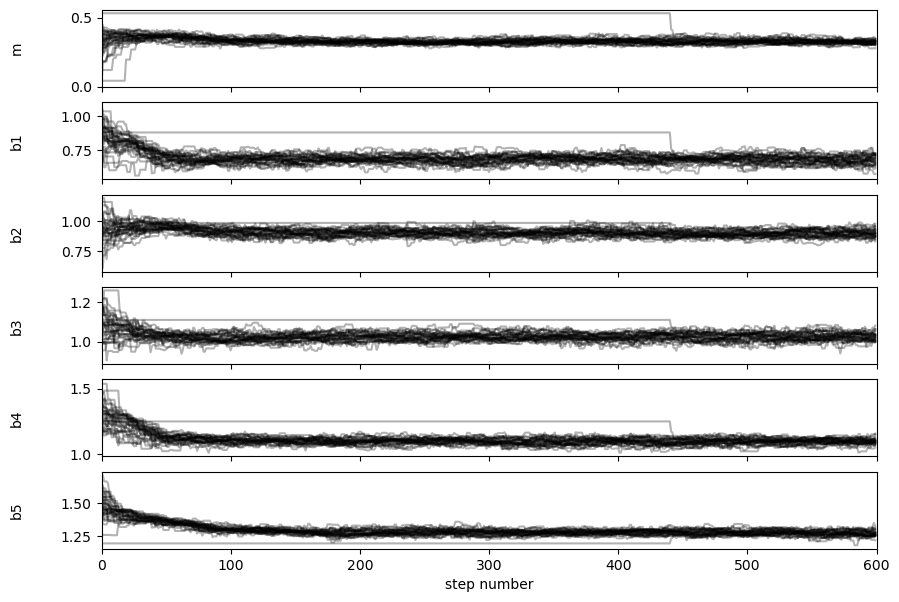

In [32]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
CHAIN = chain_all

samples = CHAIN.reshape((int(np.shape(CHAIN)[0]/32), 32, 6))
labels = ["m", "b1", "b2", "b3", "b4", "b5"]
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [44]:
def trim_chains(chain, n_steps, walkers=32):
    #n_steps: int; length to trim
    
    samples = chain.reshape((int(np.shape(chain)[0]/32), 32, 6))[n_steps:]
    return samples.reshape((int(np.shape(chain)[0] - (n_steps*32)), 6))

def remove_stuck_walkers(samples, nvars=6):
    chain = samples.reshape(np.shape(samples)[0] * np.shape(samples)[1], nvars)
    
    remove_idxs = []
    
    for i in range(nvars):
        vals, idxs, counts = np.unique(chain[:,i], return_inverse=True, return_counts=True)
        remove_idxs.append(np.where(np.isin(idxs, np.where(counts>1))))
        
    remove_mask = np.ones(len(chain))
    remove_mask[np.unique(remove_idxs)] = 0
    return remove_mask.astype(bool)

def process_stuck_chain(chain, trim_length):
    chain = trim_chains(chain, trim_length)
    samples = chain.reshape((int(np.shape(chain)[0]/32), 32, 6))
    
    chain_thinned = samples.reshape(np.shape(samples)[0] * np.shape(samples)[1], 6)
    chain_thinned = chain_thinned[remove_stuck_walkers(samples)]
    
    return chain_thinned
#     return chain_thinned[trim_length:]

In [45]:
# chain_1t1 = trim_chains(chain_1t1, 100)
# chain_2t1 = trim_chains(chain_2t1, 100)
# chain_all = trim_chains(chain_all, 100)

chain_1t1 = process_stuck_chain(chain_1t1, 100)
chain_2t1 = process_stuck_chain(chain_2t1, 100)
chain_all = process_stuck_chain(chain_all, 100)

# chain_all = process_stuck_chain(chain_all, 200)
# chain_true = trim_chains(chain_true, 100)

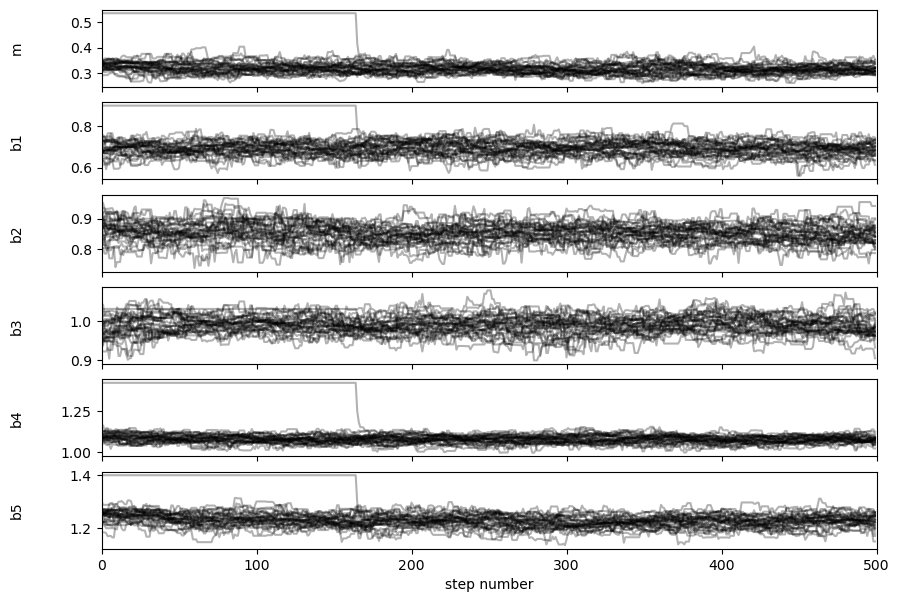

In [35]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
CHAIN = chain_1t1

samples = CHAIN.reshape((int(np.shape(CHAIN)[0]/32), 32, 6))
labels = ["m", "b1", "b2", "b3", "b4", "b5"]
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

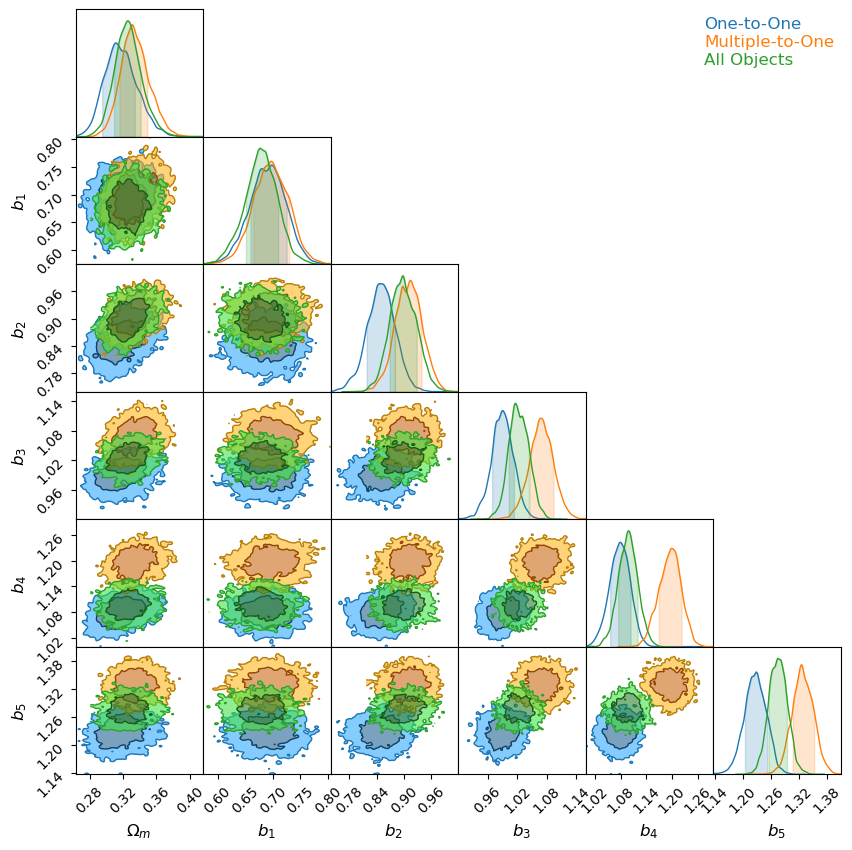

In [46]:
c1 = chain_1t1
c2 = chain_2t1
c3 = chain_all
# c4 = chain_true


c = ChainConsumer()
c.add_chain(c1, parameters=[r"$\Omega_m$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", r"$b_5$"], 
            color=COLORS[0], name='One-to-One')
c.add_chain(c2, parameters=[r"$\Omega_m$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", r"$b_5$"], 
            color=COLORS[1], name='Multiple-to-One')
c.add_chain(c3, parameters=[r"$\Omega_m$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", r"$b_5$"], 
            color=COLORS[2], name='All Objects')
# c.add_chain(c4, parameters=[r"$\Omega_m$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", r"$b_5$"], 
#             color=COLORS[3], name='Truth')
c.configure(usetex=False, shade=True, bar_shade=True)
c.plotter.plot(filename='samples/5bin');

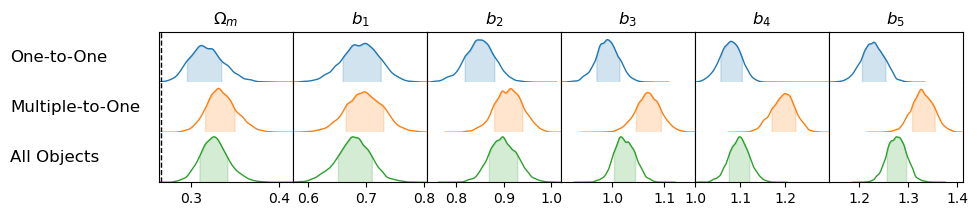

In [47]:
c = ChainConsumer()
c.add_chain(c1, parameters=[r"\Omega_m", r"b_1", r"b_2", r"b_3", r"b_4", r"b_5"], 
            color=COLORS[0], name='One-to-One')
c.add_chain(c2, parameters=[r"\Omega_m", r"b_1", r"b_2", r"b_3", r"b_4", r"b_5"], 
            color=COLORS[1], name='Multiple-to-One')
c.add_chain(c3, parameters=[r"\Omega_m", r"b_1", r"b_2", r"b_3", r"b_4", r"b_5"], 
            color=COLORS[2], name='All Objects')
# c.add_chain(c4, parameters=[r"\Omega_m", r"b_1", r"b_2", r"b_3", r"b_4", r"b_5"], 
#             color=COLORS[3], name='Truth')

c.configure(usetex=False, legend_color_text=False, bar_shade=True)
c.plotter.plot_summary(truth=[.265]);#truth="Truth",);